In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from typing import Tuple, List
from pydantic import BaseModel, Field
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load results

In [12]:
# pydantic model

class PreprocessingSteps(BaseModel):
    transformers: Tuple[
        Tuple[PCA, StandardScaler, np.ndarray, np.ndarray],
        Tuple[float, float]
    ] = Field(
        ..., 
        description="Preprocessing steps including PCA, StandardScaler, and arrays"
    )

    class Config:
        arbitrary_types_allowed = True
        json_encoders = {
            np.ndarray: lambda v: v.tolist(),
            PCA: lambda v: str(v),
            StandardScaler: lambda v: str(v)
        }


In [13]:
def load_data(dataset: str, activation: str = "relu") -> dict:
    """
    Load data from pickle files for a specific dataset.
    
    Args:
        dataset (str): Name of the dataset or specific subdirectory
    
    Returns:
        dict: A dictionary with full file paths as keys and loaded data as values
    """
    
    base_dir = "../results/datasets/real_world_data/"
    if dataset in ["circles", "spheres", "alternate_stripes"]:
        base_dir = "../results/datasets/synthetic_data"
    
    full_path = os.path.join(base_dir, dataset)
    full_path = full_path + f"/activation={activation}"

    print(full_path)
    
    data_dict = {}
    
    # Walk through the directory tree starting from the specified dataset path
    for root, dirs, files in os.walk(full_path):
        for file in files:
            # Check if the file is a pickle file
            if file.endswith('.pkl') or file.endswith('.p'):
                full_file_path = os.path.join(root, file)
                
                try:
                    # Load the pickle file
                    with open(full_file_path, "rb") as f:
                        data = pickle.load(f)
                    
                    # Store in the dictionary with full path as key
                    data_dict[full_file_path] = data
                
                except (IOError, pickle.UnpicklingError) as e:
                    print(f"Error loading {full_file_path}: {e}")
    
    return data_dict

In [14]:
def read_all_nested_files(dataset: str, activation: str = "relu"):

    base_dir = "../results/datasets/real_world_data/"
    if dataset in ["circles", "spheres", "alternate_stripes"]:
        base_dir = "../results/datasets/synthetic_data"
    
    full_path = os.path.join(base_dir, dataset)
    full_path = full_path + f"/activation={activation}"
    
    # Dictionary to store file contents with file paths as keys
    file_contents = {}
    
    # Walk through all directories and files
    for root, dirs, files in os.walk(full_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if "results_list.p" in file_path or re.search(r'^[^a-zA-Z]*\d+\.p', file_path.split("/")[-1]) is not None:
                # print(file_path)
                try:
                    content = pickle.load(open(file_path, 'rb'))
                    # Store content with full path as key
                    file_contents[file_path] = content
                except Exception as e:
                    print(f"Could not read {file_path}: {e}")
    
    return file_contents

# functions to collate the data

In [15]:
# get the explained variance objectives for train and validation

def extract_explained_variance(data: list[list[PreprocessingSteps]]) -> np.array:

    explained_variance = []
    
    for j in range(len(data)):
        
        data_run = [data[j][i][-1] for i in range(len(data[j]))]
        explained_variance.append(data_run)

    return np.array(explained_variance)

# visualise

In [18]:
def plot_percentiles(partial_data, full_data, dataset: str):
    plt.figure(figsize=(10, 6))
    # Colors for different contribution types
    colors = {'partial': 'darkred', 'full': 'darkblue'}
    linestyles = ['--', '-']
    activation_fn = 'relu'
    if dataset == 'alternate_stripes':
        activation_fn = 'cos'
    # Plot both partial and full contributions
    for data, contrib_type in [(partial_data, 'partial'), (full_data, 'full')]:
        # Compute percentiles along the first axis (runs)

        print(f"FOR contrib type {contrib_type}")
        print(f"mean {np.mean(data, axis=0)[-1]}")
        print(f"std {np.std(data, axis=0)[-1]}")
        
        p20 = np.percentile(data, 20, axis=0)
        p50 = np.percentile(data, 50, axis=0)
        p80 = np.percentile(data, 80, axis=0)
        # Create x-axis (time steps)
        x = np.arange(data.shape[1])
        # Plot for each dimension (training/validation)
        for dim in range(2):
            # Only add label for the first dimension to avoid duplicates in legend
            label = f"h={activation_fn}, objective={contrib_type}" if dim == 0 else None
            plt.plot(x, p50[:, dim], color=colors[contrib_type],
                     label=label,
                     linestyle=linestyles[dim], linewidth=1.0)
            plt.fill_between(x, p20[:, dim], p80[:, dim],
                             alpha=0.2, color=colors[contrib_type])
    
    # Increase font size for axis labels
    plt.xlabel('Time steps', fontsize=14)
    plt.ylabel("Proportion of explained variance for $\lambda_1$", fontsize=14)
    
    # Increase legend size
    plt.legend(loc='upper left', fontsize=12)
    
    # Increase tick label size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    # path_to_save = f"../results/plots/training_curve/{dataset}.pdf"
    # directory = os.path.dirname(path_to_save)
    # if not os.path.exists(directory):
    #     os.makedirs(directory)
        
    # plt.savefig(path_to_save, dpi=300)
    # plt.close()

<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
/var/folders/d5/3my7z8_d7tb6sgm4462k6n7w0000gn/T/ipykernel_63857/881879127.py:34: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("Proportion of explained variance for $\lambda_1$", fontsize=14)


FOR contrib type partial
mean [0.85308826 0.85337737]
std [0.04313549 0.0478253 ]
FOR contrib type full
mean [0.61018495 0.60795478]
std [0.07993828 0.07943187]


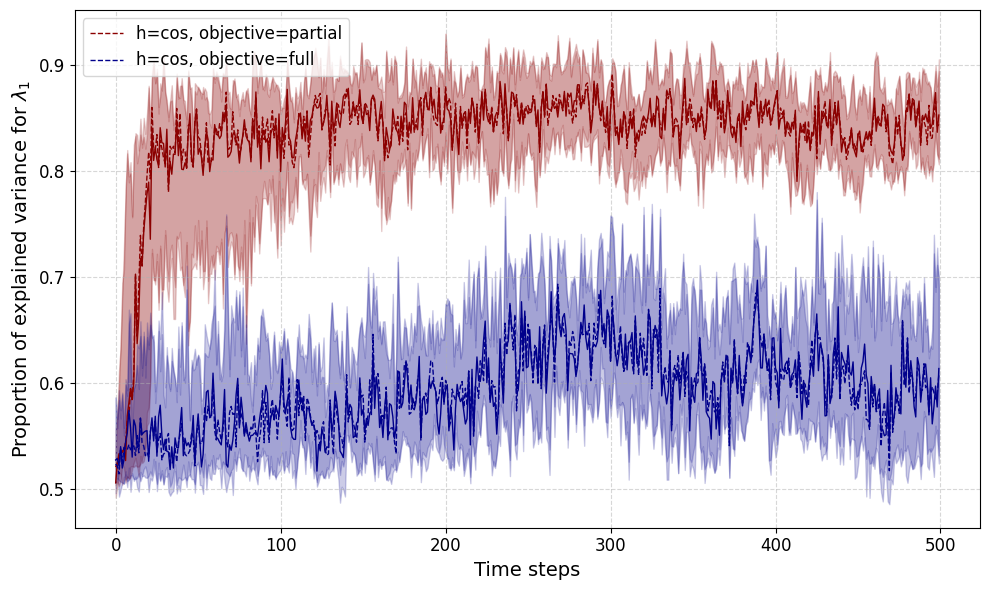

FOR contrib type partial
mean [0.78354868 0.779591  ]
std [0.07866868 0.07632584]
FOR contrib type full
mean [0.56338281 0.5626107 ]
std [0.05350998 0.05487021]


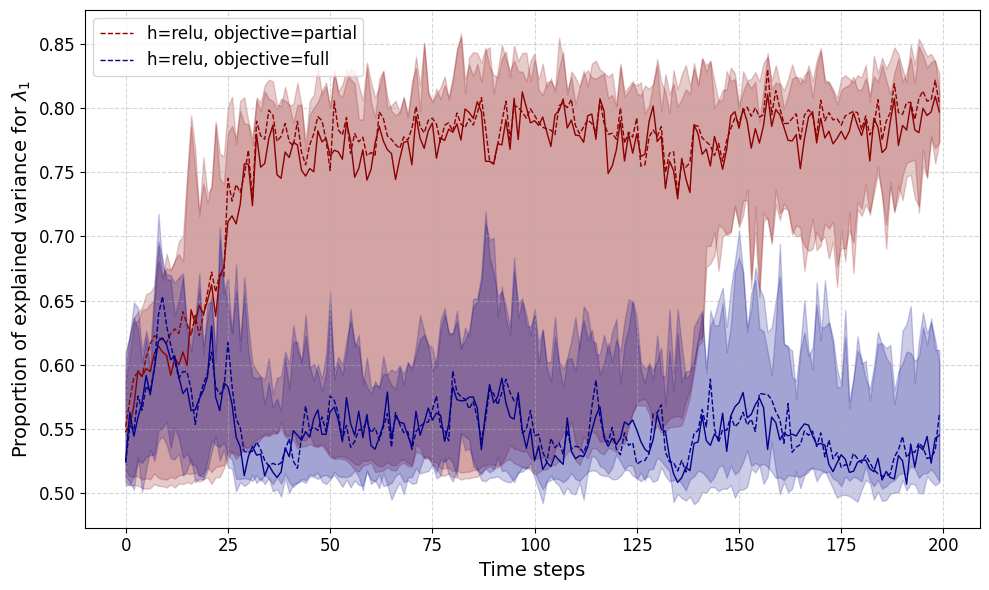

FOR contrib type partial
mean [0.63930449 0.62540234]
std [0.00972407 0.0141075 ]
FOR contrib type full
mean [0.44551673 0.4389106 ]
std [0.04756623 0.0566431 ]


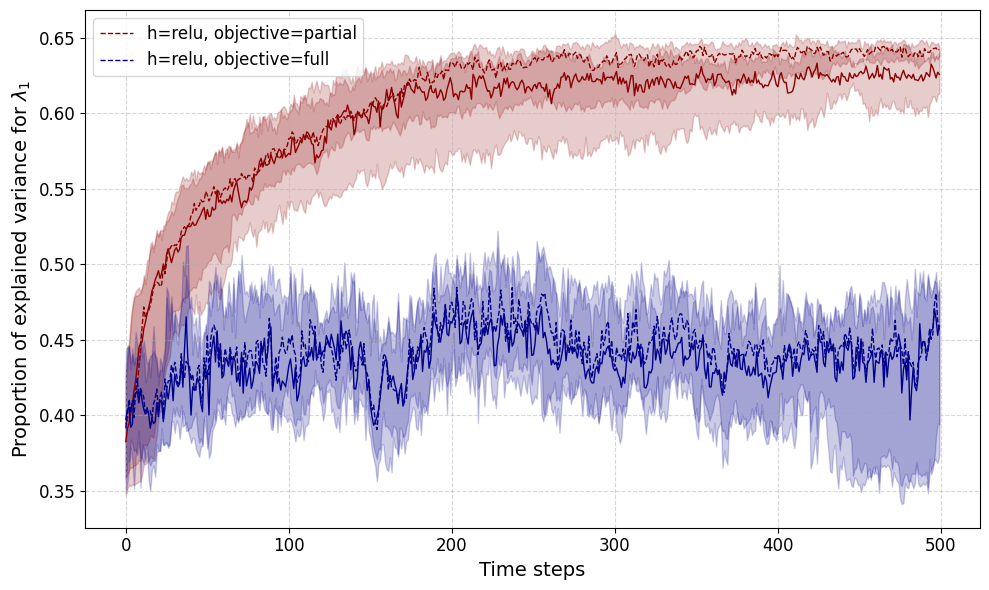

FOR contrib type partial
mean [0.40928026 0.40656899]
std [0.02170454 0.04142523]
FOR contrib type full
mean [0.38303053 0.37874366]
std [0.0187782  0.03935848]


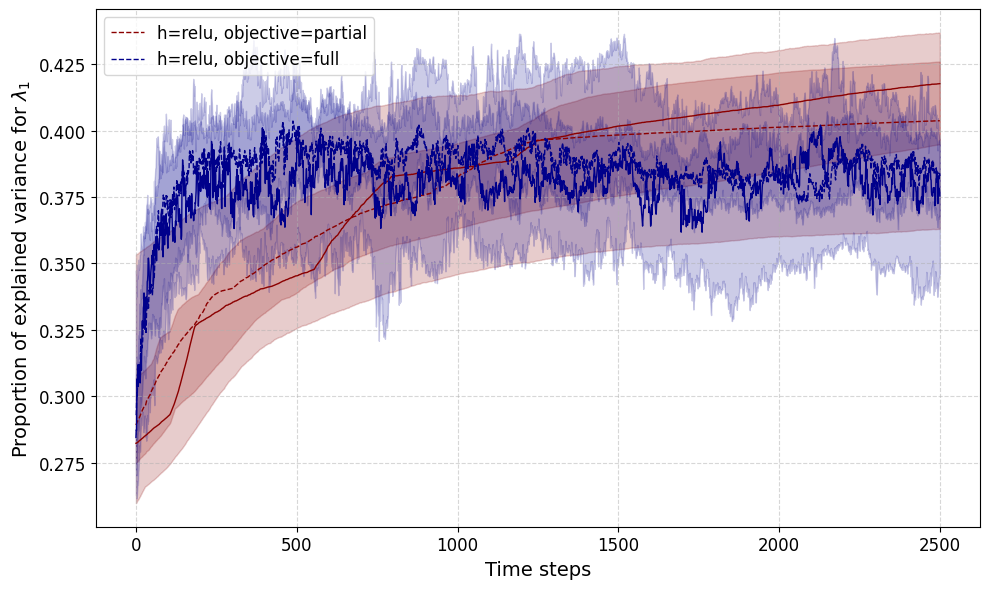

FOR contrib type partial
mean [0.27660633 0.25782595]
std [0.00769854 0.02748685]
FOR contrib type full
mean [0.2652738  0.24705216]
std [0.00852015 0.033725  ]


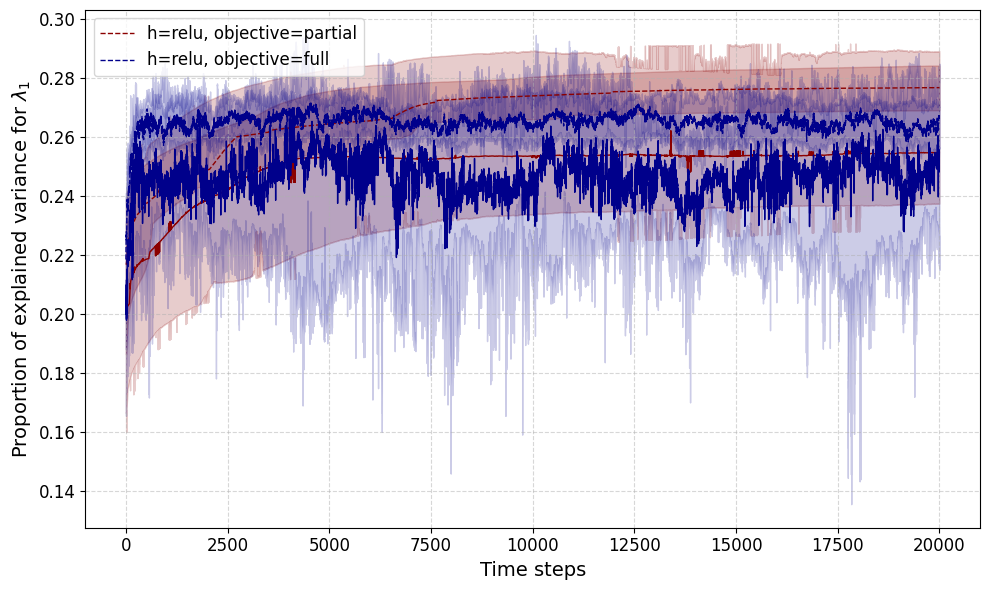

FOR contrib type partial
mean [0.2976277  0.28835853]
std [0.01185551 0.01549055]
FOR contrib type full
mean [0.27595448 0.26546564]
std [0.01466316 0.01842929]


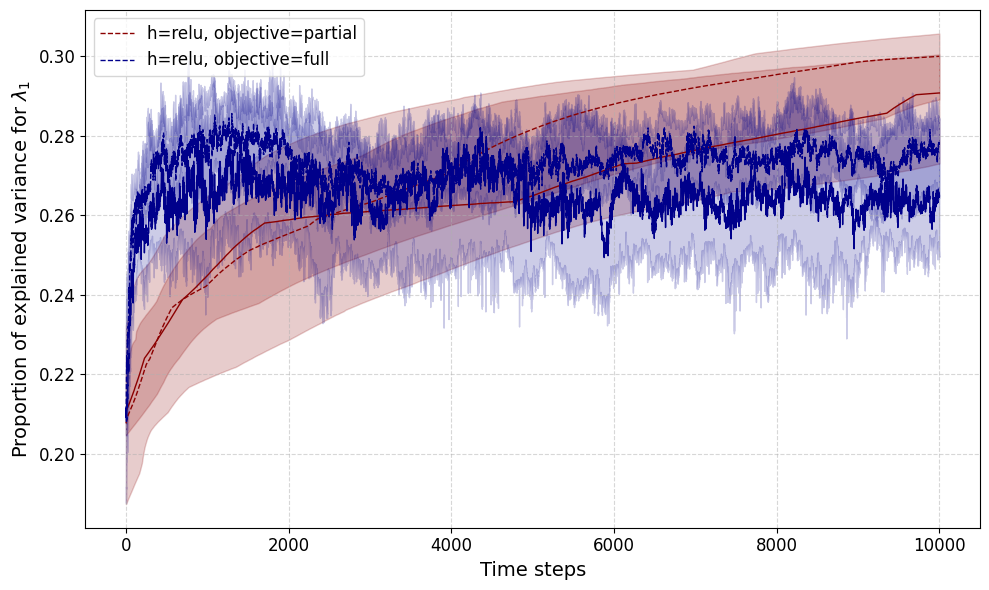

FOR contrib type partial
mean [0.26298948 0.22736594]
std [0.00739607 0.02769364]
FOR contrib type full
mean [0.21416522 0.20813836]
std [0.01795396 0.03027722]


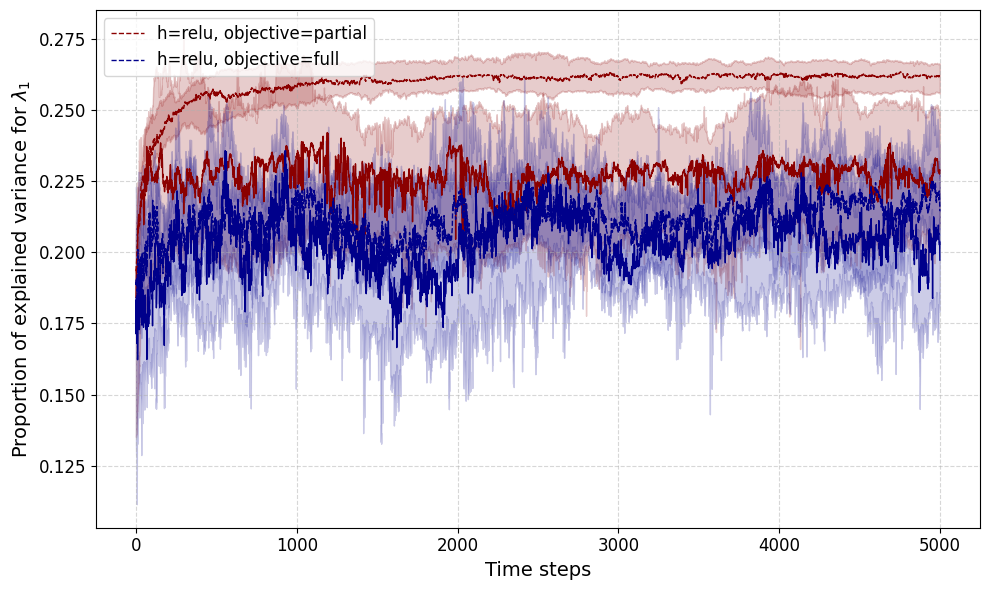

FOR contrib type partial
mean [0.15248679 0.14377274]
std [0.00501812 0.00969523]
FOR contrib type full
mean [0.14897394 0.14158134]
std [0.00317869 0.00971496]


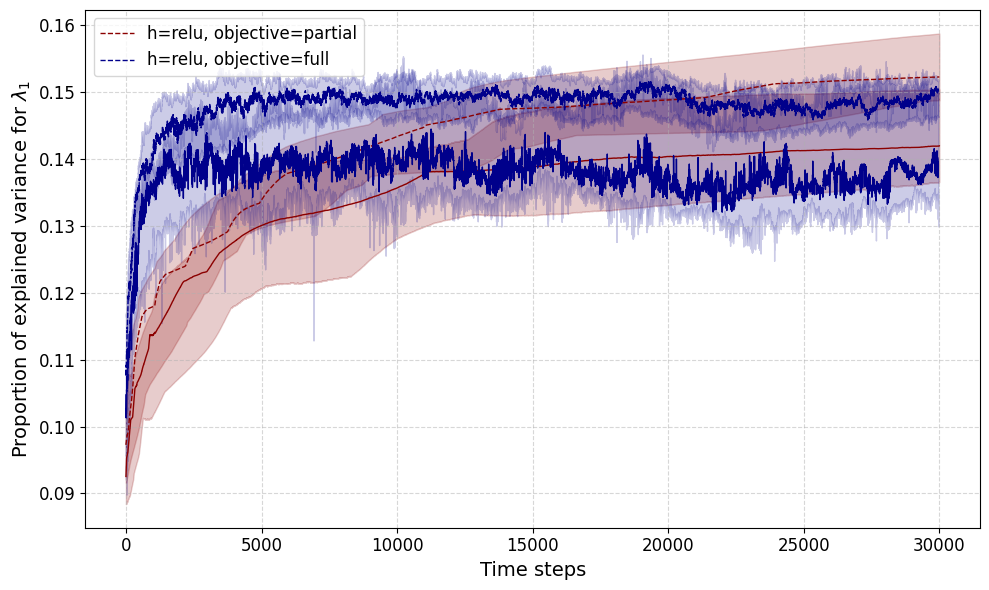

In [19]:
# Modified main loop
dataset_list = ["alternate_stripes",
                "circles",
                "spheres", 
                "wine", 
                "heart-statlog", 
                "ionosphere", 
                "breast_cancer", 
                "german_credit"]

# dataset_list = ["alternate_stripes"]

for dataset in dataset_list:
    activation = "relu"
    if dataset == "alternate_stripes":
        activation = "cos"
        
    data_dictionary = read_all_nested_files(dataset, activation)
    
    partial_contrib_data = [value for key, value in data_dictionary.items() 
                            if ('partial_contrib=True' in key)
                            and (activation in key)
                            and (("results_list.p" in key) or (re.search(r'^[^a-zA-Z]*\d+\.p', key.split("/")[-1]) is not None))]
    full_contrib_data = [value for key, value in data_dictionary.items() 
                         if ('partial_contrib=False' in key)
                         and (activation in key)
                         and (("results_list.p" in key) or (re.search(r'^[^a-zA-Z]*\d+\.p', key.split("/")[-1]) is not None))]

    # print(len(partial_contrib_data))
    
    
    explained_variance_partial = extract_explained_variance(partial_contrib_data)
    explained_variance_full = extract_explained_variance(full_contrib_data)
    
    # Plot both contributions on the same figure
    plot_percentiles(explained_variance_partial, explained_variance_full, dataset)